In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import copy
import warnings

import scipy
import scipy.integrate as integrate
from scipy import interpolate

import numpy as np 

from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table, Column, vstack

import matplotlib.pyplot as plt

import caterpillar
from caterpillar.filters import make_kfilter_file

from sedpy import observate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Derive color-terms that convert HSC or PS-1 photometry to the Merian filters

In [3]:
filter_dir = '../../data/filters/'

filter_merian = os.path.join(filter_dir, 'merian')
filter_decam = os.path.join(filter_dir, 'decam')
filter_hsc = os.path.join(filter_dir, 'hsc')
filter_ps1 = os.path.join(filter_dir, 'ps1')

### Load different filter sets

#### Organize the Merian filters

In [4]:
ls ../../data/filters/merian/

merian_n540_asahi.fits  merian_n540_model.par   merian_n708_med.par
merian_n540_asahi.txt   merian_n708_asahi.fits  merian_n708_model.par
merian_n540_avg.par     merian_n708_asahi.txt   n540/
merian_n540_med.par     merian_n708_avg.par     n708/


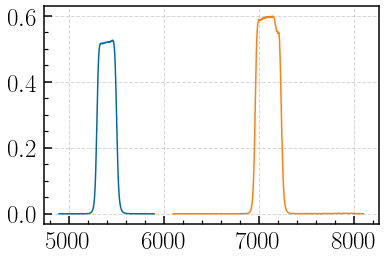

In [5]:
merian = {'name': 'merian', 'filters':
         observate.load_filters(['merian_n540_avg', 'merian_n708_avg'], directory=filter_merian)}

for i, filt in enumerate(merian['filters']):
    plt.plot(filt.wavelength, filt.transmission, label=list(['n540', 'n708'])[i], linestyle='-')

#### Organize the PS-1 filter

In [6]:
ls ../../data/filters/ps1/svo

PAN-STARRS_PS1.g.dat  PAN-STARRS_PS1.r.dat  PAN-STARRS_PS1.z.dat
PAN-STARRS_PS1.i.dat  PAN-STARRS_PS1.y.dat


In [7]:
ps1_g = Table.read(os.path.join(filter_ps1, 'svo', 'PAN-STARRS_PS1.g.dat'), format='ascii') 
ps1_r = Table.read(os.path.join(filter_ps1, 'svo', 'PAN-STARRS_PS1.r.dat'), format='ascii') 
ps1_i = Table.read(os.path.join(filter_ps1, 'svo', 'PAN-STARRS_PS1.i.dat'), format='ascii') 
ps1_z = Table.read(os.path.join(filter_ps1, 'svo', 'PAN-STARRS_PS1.z.dat'), format='ascii') 
ps1_y = Table.read(os.path.join(filter_ps1, 'svo', 'PAN-STARRS_PS1.y.dat'), format='ascii') 

In [8]:
ps1_g_file = os.path.join(filter_ps1, 'ps1_g.par')
make_kfilter_file(ps1_g['col1'], ps1_g['col2'], par_name=ps1_g_file)

ps1_r_file = os.path.join(filter_ps1, 'ps1_r.par')
make_kfilter_file(ps1_r['col1'], ps1_r['col2'], par_name=ps1_r_file)

ps1_i_file = os.path.join(filter_ps1, 'ps1_i.par')
make_kfilter_file(ps1_i['col1'], ps1_i['col2'], par_name=ps1_i_file)

ps1_z_file = os.path.join(filter_ps1, 'ps1_z.par')
make_kfilter_file(ps1_z['col1'], ps1_z['col2'], par_name=ps1_z_file)

ps1_y_file = os.path.join(filter_ps1, 'ps1_y.par')
make_kfilter_file(ps1_y['col1'], ps1_y['col2'], par_name=ps1_y_file)

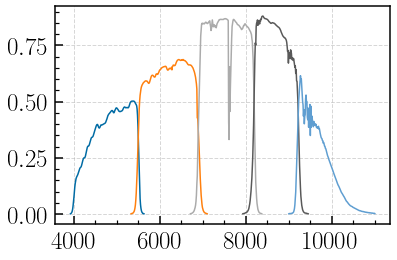

In [9]:
ps1 = {'name': 'PS1', 'filters':
       observate.load_filters(['ps1_g', 'ps1_r', 'ps1_i', 'ps1_z', 'ps1_y'], directory=filter_ps1)}

for i, filt in enumerate(ps1['filters']):
    plt.plot(filt.wavelength, filt.transmission, label=list('grizy')[i], linestyle='-')

#### Organize the DES filters

In [10]:
decam_curves = Table.read(os.path.join(filter_decam, 'STD_BANDPASSES_DR1.fits'))

In [11]:
decam_g_file = os.path.join(filter_decam, 'decam_g.par')
make_kfilter_file(decam_curves['LAMBDA'], decam_curves['g'], par_name=decam_g_file)

decam_r_file = os.path.join(filter_decam, 'decam_r.par')
make_kfilter_file(decam_curves['LAMBDA'], decam_curves['r'], par_name=decam_r_file)

decam_i_file = os.path.join(filter_decam, 'decam_i.par')
make_kfilter_file(decam_curves['LAMBDA'], decam_curves['i'], par_name=decam_i_file)

decam_z_file = os.path.join(filter_decam, 'decam_z.par')
make_kfilter_file(decam_curves['LAMBDA'], decam_curves['z'], par_name=decam_z_file)

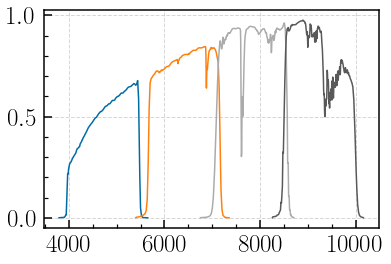

In [12]:
decam = {'name': 'decam', 'filters':
         observate.load_filters(['decam_g', 'decam_r', 'decam_i', 'decam_z'], directory=filter_decam)}

for i, filt in enumerate(decam['filters']):
    plt.plot(filt.wavelength, filt.transmission, label=list('griz')[i], linestyle='-')

#### Organize HSC filters

In [13]:
hsc = {'name': 'HSC', 'filters':
       observate.load_filters(['hsc_g', 'hsc_r', 'hsc_i', 'hsc_z', 'hsc_y'], directory=filter_hsc)}

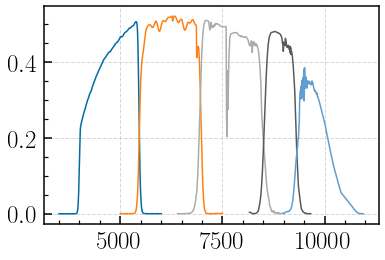

In [14]:
for i, filt in enumerate(hsc['filters']):
    plt.plot(filt.wavelength, filt.transmission, label=list('grizy')[i], linestyle='-')

#### Organize SDSS filters

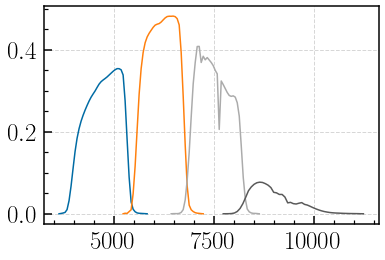

In [15]:
sdss = {'name': 'SDSS', 'filters':
       observate.load_filters(['sdss_g0', 'sdss_r0', 'sdss_i0', 'sdss_z0'])}

for i, filt in enumerate(sdss['filters']):
    plt.plot(filt.wavelength, filt.transmission, label=list('griz')[i], linestyle='-')

In [16]:
filters_use = {}

# Merian
filters_use['merian_n540_avg'] = observate.load_filters(['merian_n540_avg'], directory=filter_merian)[0]
filters_use['merian_n708_avg'] = observate.load_filters(['merian_n708_avg'], directory=filter_merian)[0]
filters_use['merian_n540_med'] = observate.load_filters(['merian_n540_med'], directory=filter_merian)[0]
filters_use['merian_n708_med'] = observate.load_filters(['merian_n708_med'], directory=filter_merian)[0]

# PS-1
filters_use['ps1_g'] = observate.load_filters(['ps1_g'], directory=filter_ps1)[0]
filters_use['ps1_r'] = observate.load_filters(['ps1_r'], directory=filter_ps1)[0]
filters_use['ps1_i'] = observate.load_filters(['ps1_i'], directory=filter_ps1)[0]
filters_use['ps1_z'] = observate.load_filters(['ps1_z'], directory=filter_ps1)[0]
filters_use['ps1_y'] = observate.load_filters(['ps1_y'], directory=filter_ps1)[0]

# DECam
filters_use['decam_g'] = observate.load_filters(['decam_g'], directory=filter_decam)[0]
filters_use['decam_r'] = observate.load_filters(['decam_r'], directory=filter_decam)[0]
filters_use['decam_i'] = observate.load_filters(['decam_i'], directory=filter_decam)[0]
filters_use['decam_z'] = observate.load_filters(['decam_z'], directory=filter_decam)[0]

# HSC
filters_use['hsc_g'] = observate.load_filters(['hsc_g'], directory=filter_hsc)[0]
filters_use['hsc_r'] = observate.load_filters(['hsc_r'], directory=filter_hsc)[0]
filters_use['hsc_i'] = observate.load_filters(['hsc_i'], directory=filter_hsc)[0]
filters_use['hsc_z'] = observate.load_filters(['hsc_z'], directory=filter_hsc)[0]
filters_use['hsc_y'] = observate.load_filters(['hsc_y'], directory=filter_hsc)[0]

# SDSS
filters_use['sdss_g'] = observate.load_filters(['sdss_g0'])[0]
filters_use['sdss_r'] = observate.load_filters(['sdss_r0'])[0]
filters_use['sdss_i'] = observate.load_filters(['sdss_i0'])[0]
filters_use['sdss_z'] = observate.load_filters(['sdss_z0'])[0]

In [17]:
for k, v in filters_use.items():
    print(k)

merian_n540_avg
merian_n708_avg
merian_n540_med
merian_n708_med
ps1_g
ps1_r
ps1_i
ps1_z
ps1_y
decam_g
decam_r
decam_i
decam_z
hsc_g
hsc_r
hsc_i
hsc_z
hsc_y
sdss_g
sdss_r
sdss_i
sdss_z


### Organize the stellar libraries

#### Gunn-Stryker Atlas

- The spectra given here are uncorrected by extinction and normalized to ST V magnitude

In [18]:
gunn_dir = '../../data/stellar/gunn_stryker/'

In [19]:
gs_type = Table.read(os.path.join(gunn_dir, 'gsspectype.fits'))

gs_files = [str(n).replace('.tab', '.fits').lower().strip() for n in gs_type['FILENAME']]

In [22]:
#import extinction

In [23]:
fits.open(os.path.join(gunn_dir, gs_files[0]))[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   20 / width of table in bytes                        
NAXIS2  =                  503                                                  
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    5                                                  
TTYPE1  = 'WAVELENGTH'         / label for field   1                            
TFORM1  = '1E      '           / data format of field: 4-byte REAL              
TUNIT1  = 'Angstroms'          / physical unit of field                         
TTYPE2  = 'FLUX    '           / label for field   2                            
TFORM2  = '1E      '        

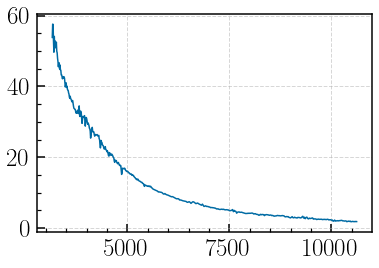

In [24]:
star = Table.read(os.path.join(gunn_dir, gs_files[0]))

plt.plot(star['WAVELENGTH'], star['FLUX'])

In [25]:
observate.load_filters(['hsc_g', 'hsc_r', 'hsc_i', 'hsc_z'], directory=filter_hsc)[0].vega_mag(star['WAVELENGTH'], star['FLUX'])

-23.86493326750943

In [26]:
gs_sum = []

for spec in gs_files:
    star = Table.read(os.path.join(gunn_dir, spec))
    wave, flux = star['WAVELENGTH'], star['FLUX'] 
    
    star_sum = {}
    star_sum['catalog'] = "gunn_stryker"
    star_sum['name'] = spec.replace('.fits', '')
    
    for k, v in filters_use.items():
        star_sum[k + '_vega'] = v.vega_mag(wave, flux) + 21.10
        star_sum[k + '_ab'] = v.ab_mag(wave, flux) + 21.10
    
    gs_sum.append(star_sum)

gs_tab = Table(gs_sum)

In [34]:
gs_tab.write('../../data/gunn_stryker_sum.fits')

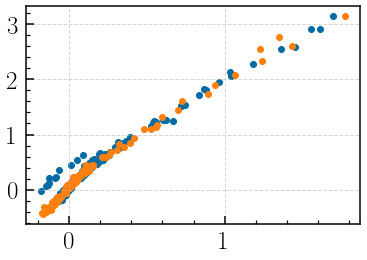

In [38]:
plt.scatter(gs_tab['merian_n708_avg_ab'] - gs_tab['hsc_i_ab'], gs_tab['hsc_r_ab'] - gs_tab['hsc_i_ab'])
plt.scatter(pk_tab['merian_n708_avg_ab'] - pk_tab['hsc_i_ab'], pk_tab['hsc_r_ab'] - pk_tab['hsc_i_ab'])

#### Pickles Atlas

- UVILIB and UVKLIB, which cover the spectral range 1150-10620 Å, and 1150-25000 Å, respectively.
- Fluxes are tabulated in units of ergs cm2 s−1 Å−1 and were calculated by normalizing the original fluxes in the Pickles V band to a 0 magnitude in vegamag. 

In [28]:
pks_dir = '../../data/stellar/pickles/'

In [29]:
pk_type = Table.read(os.path.join(pks_dir, 'pickles.fits'))

pk_files = [str(n).lower().strip() + '.fits' for n in pk_type['FILENAME']]

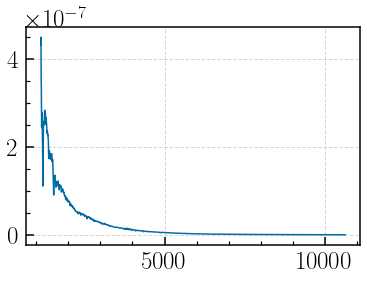

In [30]:
star = Table.read(os.path.join(pks_dir, pk_files[1]))

plt.plot(star['WAVELENGTH'], star['FLUX'])

In [31]:
observate.load_filters(['hsc_g', 'hsc_r', 'hsc_i', 'hsc_z'], directory=filter_hsc)[0].ab_mag(star['WAVELENGTH'], star['FLUX'])

-0.2819644981086986

In [32]:
pk_sum = []

for spec in pk_files:
    star = Table.read(os.path.join(pks_dir, spec))
    wave, flux = star['WAVELENGTH'], star['FLUX'] 
    
    star_sum = {}
    star_sum['catalog'] = "pickles"
    star_sum['name'] = spec.replace('.fits', '')
    
    for k, v in filters_use.items():
        star_sum[k + '_vega'] = v.vega_mag(wave, flux)
        star_sum[k + '_ab'] = v.ab_mag(wave, flux)
    
    pk_sum.append(star_sum)

pk_tab = Table(pk_sum)

In [36]:
pk_tab.write('../../data/pickles_sum.fits')

In [39]:
len(pk_tab)

131

In [33]:
def get_color_terms(catalog, target, ref_1='ps1_g_ab', ref_2='ps1_i_ab', 
                    order=3, color_min=-1, color_max=4.5, show=True):
    """Derive the color terms for photometric calibration."""
    data = Table()
    data['x'] = catalog[ref_1] - catalog[ref_2]
    data['y'] = catalog[target] - catalog[ref_1]
    data.sort('x')

    color_mask = (data['x'] >= color_min) & (data['x'] <= color_max)
    color_term = np.polyfit(data['x'][color_mask], data['y'][color_mask], order)

    print(color_term)

    x_pre = np.linspace(np.min(data['x']), np.max(data['x']), 100)
    y_pre = np.poly1d(color_term)(x_pre)
    
    if show:
        plt.scatter(gs_tab[ref_1] - gs_tab[ref_2], gs_tab[target] - gs_tab[ref_1], color='orangered')
        plt.scatter(pk_tab[ref_1] - pk_tab[ref_2], pk_tab[target] - pk_tab[ref_1], color='dodgerblue')
        plt.plot(x_pre, y_pre, linestyle='--', alpha=0.8, linewidth=4, c='k')
    
    return color_term, x_pre, y_pre

### Calibration

#### PS-1 to DECam 

- Based on the LegacySurvey values [here](https://www.legacysurvey.org/dr9/description/)

[-0.00518216  0.00856417  0.02749651  0.00758127]


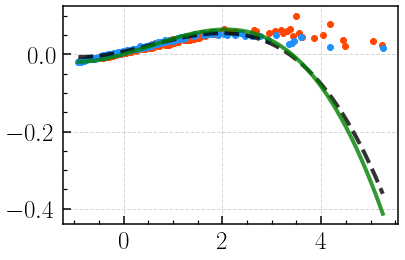

In [119]:
color_term, x_pre, y_pre = get_color_terms(
    pk_tab, 'decam_g_ab', ref_1='ps1_g_ab', ref_2='ps1_i_ab', 
    order=3, color_min=-0.2, color_max=2.7)

y_ref = 0.00062 + 0.03604 * x_pre + 0.01028 * (x_pre ** 2) - 0.00613 * (x_pre ** 3)
plt.plot(x_pre, y_ref, linestyle='-', alpha=0.8, linewidth=4, c='g')

#y_ref = 0.005728 + 0.061749 * x_pre - 0.001125 * (x_pre ** 2)
#plt.plot(x_pre, y_ref, linestyle='-', alpha=0.8, linewidth=4, c='g')

[-0.00808441 -0.00644746 -0.00018819]


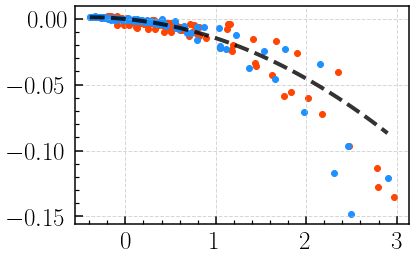

In [122]:
color_term, x_pre, y_pre = get_color_terms(
    pk_tab, 'hsc_r_ab', ref_1='ps1_r_ab', ref_2='ps1_i_ab', 
    order=2, color_min=-0.4, color_max=1.8)

#y_ref = 0.005728 + 0.061749 * x_pre - 0.001125 * (x_pre ** 2)
#plt.plot(x_pre, y_ref, linestyle='-', alpha=0.8, linewidth=4, c='g')

#y_ref = -0.005362 - 0.221551 * x_pre - 0.308279 * (x_pre ** 2)
#plt.plot(x_pre, y_ref, linestyle='-', alpha=0.8, linewidth=4, c='g')

### DECam color terms

#### g-band

[-0.00448386  0.04587468  0.00638766]


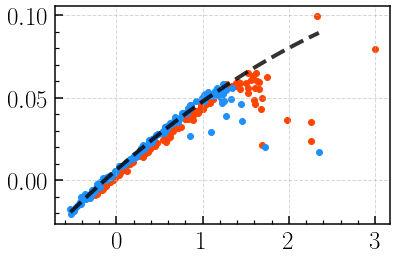

In [126]:
# g-band: PS-1 to DECam 
color_term, x_pre, y_pre = get_color_terms(
    pk_tab, 'decam_g_ab', ref_1='ps1_g_ab', ref_2='ps1_r_ab', 
    order=2, color_min=-1.0, color_max=1.2)

[-0.01839842 -0.08986856 -0.00801539]


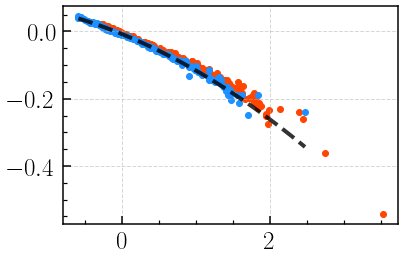

In [135]:
# g-band: SDSS to DECam 
color_term, x_pre, y_pre = get_color_terms(
    pk_tab, 'decam_g_ab', ref_1='sdss_g_ab', ref_2='sdss_r_ab', 
    order=2, color_min=-1.0, color_max=1.8)

[-2.99372789e-03 -1.52487472e-02 -5.08999450e-05]


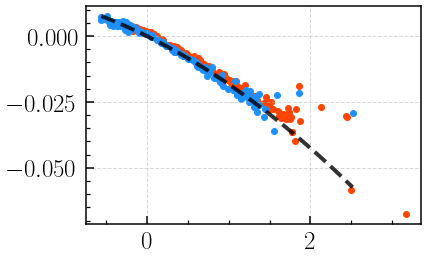

In [136]:
# g-band: HSC to DECam 
color_term, x_pre, y_pre = get_color_terms(
    pk_tab, 'decam_g_ab', ref_1='hsc_g_ab', ref_2='hsc_r_ab', 
    order=2, color_min=-1.0, color_max=1.4)

#### r-band

[ 0.01892798 -0.18730394 -0.00677473]


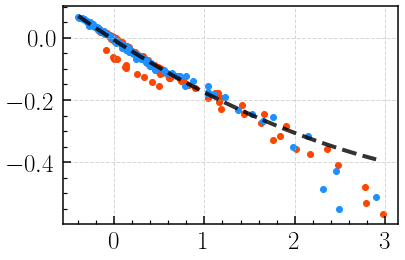

In [177]:
# r-band: PS-1 to DECam 
color_term, x_pre, y_pre = get_color_terms(
    pk_tab, 'decam_r_ab', ref_1='ps1_r_ab', ref_2='ps1_i_ab', 
    order=2, color_min=-1.0, color_max=2.2)

[ 0.02519786 -0.16953227 -0.00789952]


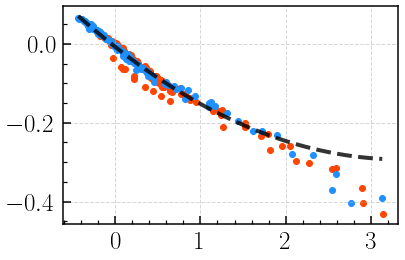

In [176]:
# r-band: HSC to DECam 
color_term, x_pre, y_pre = get_color_terms(
    pk_tab, 'decam_r_ab', ref_1='hsc_r_ab', ref_2='hsc_i_ab', 
    order=2, color_min=-1.0, color_max=2.2)

[ 0.01604172 -0.20261535 -0.00774389]


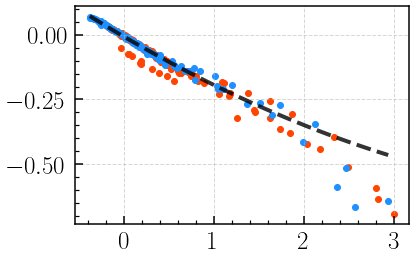

In [178]:
# r-band: SDSS to DECam 
color_term, x_pre, y_pre = get_color_terms(
    pk_tab, 'decam_r_ab', ref_1='sdss_r_ab', ref_2='sdss_i_ab', 
    order=2, color_min=-1.0, color_max=2.2)

#### i-band

[-0.01132082 -0.2829558   0.00122043]


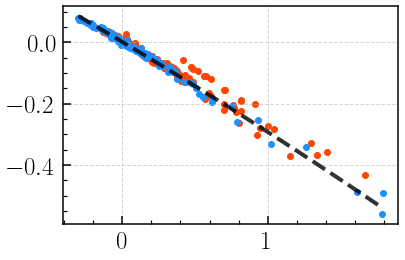

In [180]:
# i-band: PS-1 to DECam 
color_term, x_pre, y_pre = get_color_terms(
    pk_tab, 'decam_i_ab', ref_1='ps1_i_ab', ref_2='ps1_z_ab', 
    order=2, color_min=-1.0, color_max=1.4)

[ 0.00546054 -0.13140312  0.0010196 ]


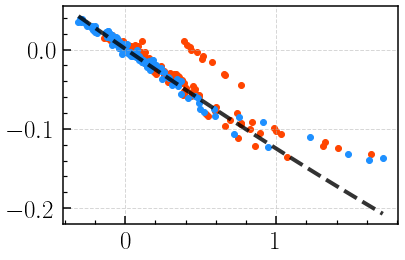

In [182]:
# i-band: HSC to DECam 
color_term, x_pre, y_pre = get_color_terms(
    pk_tab, 'decam_i_ab', ref_1='hsc_i_ab', ref_2='hsc_z_ab', 
    order=2, color_min=-1.0, color_max=1.0)

[-2.94166154e-02 -2.74828138e-01  1.88868013e-04]


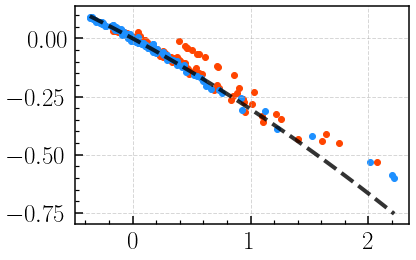

In [184]:
# i-band: SDSS to DECam 
color_term, x_pre, y_pre = get_color_terms(
    pk_tab, 'decam_i_ab', ref_1='sdss_i_ab', ref_2='sdss_z_ab', 
    order=2, color_min=-1.0, color_max=1.2)

#### z-band

[-0.057955   -0.52047945 -0.00878676]


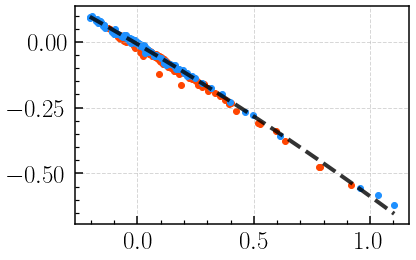

In [186]:
# z-band: PS-1 to DECam 
color_term, x_pre, y_pre = get_color_terms(
    pk_tab, 'decam_z_ab', ref_1='ps1_z_ab', ref_2='ps1_y_ab', 
    order=2, color_min=-1.0, color_max=1.0)

[-0.12298171 -0.28466837 -0.00132439]


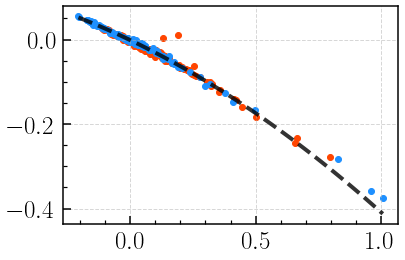

In [188]:
# z-band: HSC to DECam 
color_term, x_pre, y_pre = get_color_terms(
    pk_tab, 'decam_z_ab', ref_1='hsc_z_ab', ref_2='hsc_y_ab', 
    order=2, color_min=-1.0, color_max=0.5)

[ 0.01564714  0.11311922 -0.00598584]


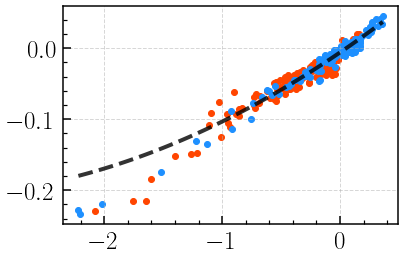

In [189]:
# z-band: SDSS to DECam 
color_term, x_pre, y_pre = get_color_terms(
    pk_tab, 'decam_z_ab', ref_1='sdss_z_ab', ref_2='sdss_i_ab', 
    order=2, color_min=-1.0, color_max=0.5)

#### N708

[ 0.09079348 -0.69377675 -0.01508987]


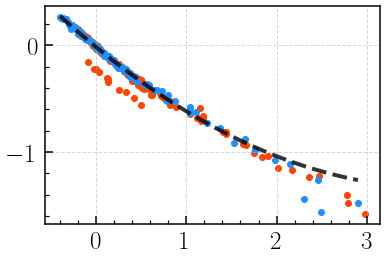

In [204]:
# N708: PS-1 to DECam 
color_term, x_pre, y_pre = get_color_terms(
    pk_tab, 'merian_n708_avg_ab', ref_1='ps1_r_ab', ref_2='ps1_i_ab', 
    order=2, color_min=-1.0, color_max=2.0)

[ 0.09132738 -0.64368838 -0.01978413]


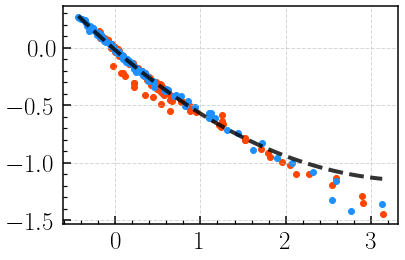

In [205]:
# N708: HSC to DECam 
color_term, x_pre, y_pre = get_color_terms(
    pk_tab, 'merian_n708_avg_ab', ref_1='hsc_r_ab', ref_2='hsc_i_ab', 
    order=2, color_min=-1.0, color_max=2.0)

[ 0.08959316 -0.71755905 -0.01428724]


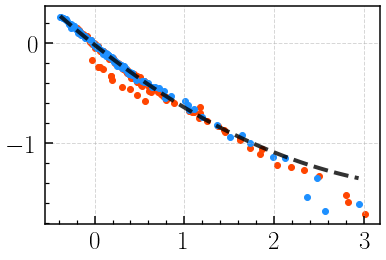

In [206]:
# N708: SDSS to DECam 
color_term, x_pre, y_pre = get_color_terms(
    pk_tab, 'merian_n708_avg_ab', ref_1='sdss_r_ab', ref_2='sdss_i_ab', 
    order=2, color_min=-1.0, color_max=2.0)

#### N540

[-0.00958104 -0.50968428 -0.02635164]


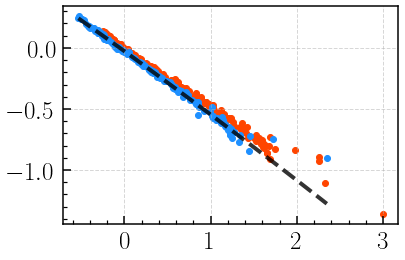

In [208]:
# N540: PS-1 to DECam 
color_term, x_pre, y_pre = get_color_terms(
    pk_tab, 'merian_n540_avg_ab', ref_1='ps1_g_ab', ref_2='ps1_r_ab', 
    order=2, color_min=-1.0, color_max=1.5)

[-0.00202415 -0.53715834 -0.03015158]


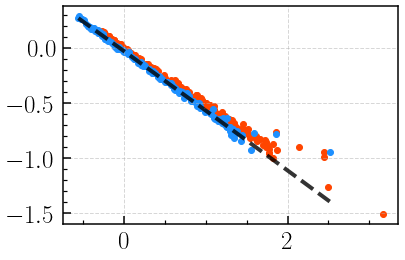

In [209]:
# N540: HSC to DECam 
color_term, x_pre, y_pre = get_color_terms(
    pk_tab, 'merian_n540_avg_ab', ref_1='hsc_g_ab', ref_2='hsc_r_ab', 
    order=2, color_min=-1.0, color_max=1.5)

[-0.01510509 -0.57665033 -0.03359776]


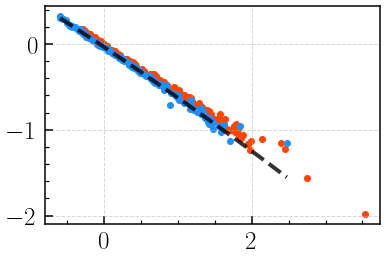

In [211]:
# N540: SDSS to DECam 
color_term, x_pre, y_pre = get_color_terms(
    pk_tab, 'merian_n540_avg_ab', ref_1='sdss_g_ab', ref_2='sdss_r_ab', 
    order=2, color_min=-1.0, color_max=1.5)